Contents:
- importing df_pt_10K.pkl
- splitting it into training and test set
- tokenization and vectorization
- SVM classification
	- SVM with tokenized lyrics - no optimization
	- SVM with tokenized lyrics - with parameter optimization
- Naive Bayes
- Decision Tree
- Random Forest
- LSTM
- CNN
- LSTM with FT
- CNN with FT
- LSTM with W2V
- CNN with W2V

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import spacy
import re
import spacy.cli
spacy.cli.download('pt_core_news_lg')
nlp = spacy.load('pt_core_news_lg')
import  nltk
print(nltk.__version__)
import pickle
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
3.7


In [3]:
import keras.utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalMaxPool1D
from keras.layers import LSTM
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras import Model
from keras.utils import to_categorical
from keras.utils import pad_sequences 


#Importing the portuguese songs dataset

In [5]:
with open ('/content/drive/MyDrive/Progetto_TA_2022/pickled_df/df_pt_10K.pkl', mode='br') as inputfile:
  df_pt = pickle.load(inputfile)

In [6]:
df_pt

,Artist,Song,Genre,Language,Lyrics
0,green day,16 (tablatura),Pop,pt,intro verso e b g d a e refrão e b g d a e pas...
1,edson e hudson,uma canção pra você,Pop,pt,como uma flecha em meu coração entrou rasgando...
2,luan santana,garotas não merecem chorar,Pop,pt,ela é uma mulher menina que precisa urgentemen...
3,zeze di camargo e luciano,solidão no seu lugar,Pop,pt,senta de frente ao espelho se olhando brinca c...
4,14 bis,pele de verão,Rock,pt,cheiro maneiro de verão pele perto do sol dent...
...,...,...,...,...,...
9995,jota quest,celebração do inútil desejo,Rock,pt,por que você me faz andar sem rumo agora se nã...
9996,o rappa,auto-reverse,Rock,pt,felizes de uma maneira geral geral estamos viv...
9997,raul seixas,vera verinha,Rock,pt,vera verinha vera verás que serás minha sempre...
9998,projota,eu não sou nada,Pop,pt,estrofe alkappa sinceramente não acredito que ...


In [7]:
df_pt.shape

(10000, 5)

#Splitting the dataset in training set and test set

In [8]:
import sklearn
from sklearn.model_selection import train_test_split

In [9]:
pt_train, pt_test = sklearn.model_selection.train_test_split(df_pt, test_size=0.20, train_size=0.80)

In [10]:
pt_train.shape

(8000, 5)

In [11]:
pt_test.shape

(2000, 5)

In [12]:
df_pt['Genre'].value_counts() 

Pop           5418
Rock          3853
Indie          359
Metal          141
Folk           130
Electronic      63
Jazz            28
R&B              8
Name: Genre, dtype: int64

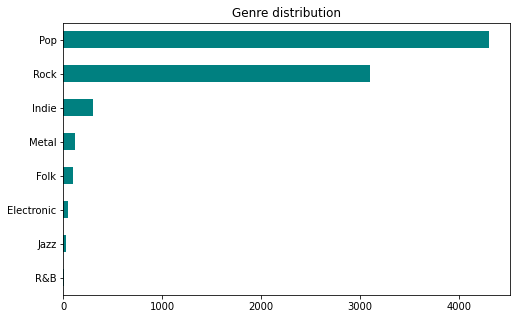

In [13]:
plt.rcParams['figure.figsize'] = [8,5]
x = pt_train['Genre'].value_counts().sort_values(ascending = True)
plt.title("Genre distribution")
x.plot(kind ='barh', color="teal")

#Tokenizing the lyrics with spacy

In [14]:
x_train = pt_train['Lyrics'].tolist()
y_train = pt_train['Genre'].tolist()

In [15]:
x_test = pt_test['Lyrics'].tolist()
y_test = pt_test['Genre'].tolist()

In [16]:
len(x_train), len(y_train), len(x_test), len(y_test)

(8000, 8000, 2000, 2000)

In [17]:
set(y_train)

{'Electronic', 'Folk', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock'}

In [18]:
sample_idx = 1345
x_train[sample_idx]

'pra que toda essa inteligência se você põe tudo a perder engana que pensa mas não pensa se rende pro mal e não pro bem agora compare as diferenças o que não existe entre eu e você estamos num mundo de incertezas nós somos o medo de viver por que não repara a experiência descer os degraus da evolução com charles darwin resignado voltando pelado na contra mão seremos macacos de novo não mataremos mais por dinheiro apenas por instinto abortados os desejos restará o ímpeto redescobriremos o fogo e o poder há de virar razão pra você ainda seremos macacos outra vez'

In [19]:
y_train[sample_idx]

'Rock'

In [20]:
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

stopword_list = stopwords.words('portuguese')
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [21]:
def spacy_tokenizer (text):
   
    doc = nlp(text)

    #lemmatizing tokens and lowering case
    lemmas = [token.lemma_.lower() for token in doc]

    #removing stopwords and punctuations
    lemmas_stop= [token for token in lemmas if token not in stopword_list and token not in punctuations]  

    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas_stop,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas_stop,3)] 
    
    all_tokens = list()
    all_tokens.extend(lemmas_stop)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

#Token vectorization with CountVectorizer and spacy_tokenizer function above

In [22]:
vectors = CountVectorizer (analyzer = spacy_tokenizer, min_df = 10)

In [23]:
print ('fit')
vectors.fit(x_train)
print('transform')
x_train_tok = vectors.transform(x_train)
x_test_tok = vectors.transform(x_test)
print ('done')

fit
transform
done


In [24]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/pt_x_train_tok.pkl', 'wb') as outfile:
  pickle.dump(x_train_tok, outfile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/pt_x_test_tok.pkl', 'wb') as outfile:
  pickle.dump(x_test_tok, outfile)

In [25]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/pt_x_train_tok.pkl', mode = 'br') as infile:
  x_train_tok = pickle.load(infile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/pt_x_test_tok.pkl', mode = 'br') as infile:
  x_test_tok = pickle.load(infile)

In [26]:
len(vectors.vocabulary_)

11034

In [27]:
vectors.vocabulary_

{'diga': 8092,
 'nunca': 9525,
 'historia': 8801,
 'ir': 8959,
 'ter': 10615,
 'fim': 8561,
 'plano': 9819,
 'desigual': 8038,
 'em o': 8232,
 'completo': 7695,
 'querer': 10056,
 'assim': 7069,
 'vivo': 10931,
 'sonho': 10489,
 'de o': 7938,
 'a o': 6770,
 'juventude': 9017,
 'mostrar': 9395,
 'caminho': 7428,
 'vir': 10911,
 'deixar': 7961,
 'tudo': 10766,
 'pra': 9889,
 'trás': 10761,
 'vida': 10888,
 'reservar': 10178,
 'gente': 8719,
 'tempo': 10603,
 'paz': 9702,
 'hora': 8811,
 'aprender': 7009,
 'amor': 6947,
 'poder': 9831,
 'mudar': 9410,
 'demais': 7971,
 'hoje': 8803,
 'tão': 10772,
 'longe': 9135,
 'lá': 9161,
 'onde': 9573,
 'esconder': 8332,
 'esquecer': 8382,
 'intriga': 8940,
 'r': 10073,
 'ligar': 9099,
 'briga': 7334,
 'BI_ir_ter': 3193,
 'BI_ter_fim': 5383,
 'BI_querer_assim': 4651,
 'BI_sonho_de o': 5133,
 'BI_a o_fim': 13,
 'BI_ir_mostrar': 3134,
 'BI_mostrar_caminho': 3533,
 'BI_vir_deixar': 6010,
 'BI_deixar_tudo': 1665,
 'BI_tudo_pra': 5623,
 'BI_pra_trás': 449

#SVM Classification

---



---



Classification report:
              precision    recall  f1-score   support

  Electronic       1.00      0.22      0.36        18
        Folk       1.00      0.10      0.19        29
       Indie       0.50      0.05      0.09        61
        Jazz       1.00      0.25      0.40         4
       Metal       0.33      0.04      0.07        27
         Pop       0.80      0.85      0.83      1114
         R&B       0.00      0.00      0.00         1
        Rock       0.70      0.74      0.72       746

    accuracy                           0.76      2000
   macro avg       0.67      0.28      0.33      2000
weighted avg       0.75      0.76      0.74      2000

Confusion matrix:
[[  4   0   1   0   0   4   0   9]
 [  0   3   0   0   0  16   0  10]
 [  0   0   3   0   1  18   0  39]
 [  0   0   0   1   0   1   0   2]
 [  0   0   0   0   1   8   0  18]
 [  0   0   0   0   1 952   0 161]
 [  0   0   0   0   0   0   0   1]
 [  0   0   2   0   0 193   0 551]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


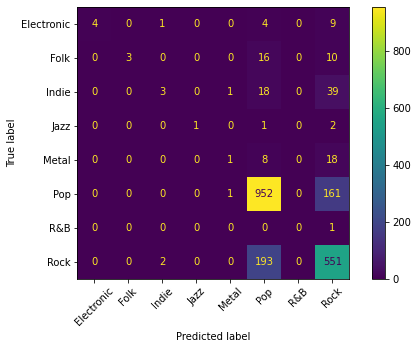

In [28]:
svm_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(x_train,y_train)
predictions = svm_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

ConfusionMatrixDisplay.from_estimator(svm_pipeline, x_test, y_test)  
plt.xticks(rotation=45)
plt.show()

SVM classification with tokenized lyrics - with  optimization of parameters

GridSearch application:

In [29]:
opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

param_grid = [{'sel__k': [1000, 2000, 3000,'all'], 'learner__C': [0.01, 0.1, 1, 10, 100]}]
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, cv=None, n_jobs = 3, verbose=True).fit(x_train_tok,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [30]:
SVM_opt_search.best_params_

{'learner__C': 1, 'sel__k': 'all'}

In [31]:
SVM_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x7f35018dc710>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=1))])

In [32]:
opt_predictions = SVM_opt_search.best_estimator_.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       1.00      0.22      0.36        18
        Folk       1.00      0.17      0.29        29
       Indie       0.69      0.15      0.24        61
        Jazz       1.00      0.25      0.40         4
       Metal       0.67      0.07      0.13        27
         Pop       0.80      0.85      0.83      1114
         R&B       0.00      0.00      0.00         1
        Rock       0.69      0.74      0.71       746

    accuracy                           0.76      2000
   macro avg       0.73      0.31      0.37      2000
weighted avg       0.76      0.76      0.74      2000

Confusion matrix:
[[  4   0   0   0   0   4   0  10]
 [  0   5   0   0   0  15   0   9]
 [  0   0   9   0   0   9   0  43]
 [  0   0   0   1   0   0   0   3]
 [  0   0   1   0   2  10   0  14]
 [  0   0   1   0   0 949   0 164]
 [  0   0   0   0   0   1   0   0]
 [  0   0   2   0   1 193   0 550]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features that weight more on classification:

In [33]:
tokenizer = vectors
selector = svm_pipeline.named_steps['sel']
classifier = svm_pipeline.named_steps['learner']

In [34]:
feature_names = tokenizer.get_feature_names_out()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

9333

In [35]:
feats_w_score[:100],feats_w_score[-100:]

([(0.4055897284342944, False, 'BI_acabar_ir'),
  (0.4055897284342944, False, 'BI_aliviar_dor'),
  (0.4055897284342944, False, 'BI_amor_ainda'),
  (0.4055897284342944, False, 'BI_aqui_ninguém'),
  (0.4055897284342944, False, 'BI_chegar_fim'),
  (0.4055897284342944, False, 'BI_coração_viver'),
  (0.4055897284342944, False, 'BI_de o_de o'),
  (0.4055897284342944, False, 'BI_deixar_ir'),
  (0.4055897284342944, False, 'BI_deixar_nada'),
  (0.4055897284342944, False, 'BI_dia_voltar'),
  (0.4055897284342944, False, 'BI_dona_de o'),
  (0.4055897284342944, False, 'BI_em o_olho'),
  (0.4055897284342944, False, 'BI_entrar_em um'),
  (0.4055897284342944, False, 'BI_falar_nunca'),
  (0.4055897284342944, False, 'BI_fazer_de o'),
  (0.4055897284342944, False, 'BI_fazer_frio'),
  (0.4055897284342944, False, 'BI_gente_ir'),
  (0.4055897284342944, False, 'BI_gente_sempre'),
  (0.4055897284342944, False, 'BI_hora_ir'),
  (0.4055897284342944, False, 'BI_ir_aumentar'),
  (0.4055897284342944, False, 'BI_ir_

In [36]:
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

2781

In [37]:
feats_w_classifier_weight[-100:]

[(0.38111305190857675, 'doze'),
 (0.3823726308411462, 'BI_gostar_de ela'),
 (0.3836124462651372, 'BI_querer_ficar'),
 (0.3836334106087244, 'BI_hey_hey'),
 (0.38469445594403257, 'erva'),
 (0.38503795188918594, 'confusão'),
 (0.3859203315352217, 'BI_aí_ter'),
 (0.38619388762207135, 'BI_vir_gente'),
 (0.38970502362083614, 'BI_sempre_tão'),
 (0.39142968251273474, 'BI_acabar_querer'),
 (0.39363260608957873, 'BI_ir_deus'),
 (0.39386254514863606, 'consigo'),
 (0.3957104584615095, 'BI_em o_escuridão'),
 (0.3967146104073056, 'alessandra'),
 (0.3980874154470361, 'TRI_de o_coração_ir'),
 (0.39928800298024736, 'BI_em o_imaginação'),
 (0.40657958362438357, 'BI_todo_vez'),
 (0.41226550248732835, 'BI_pra_valer'),
 (0.4169951852533768, 'BI_acender_luz'),
 (0.4197889159808098, 'círculo'),
 (0.42074335986870326, 'favelao'),
 (0.4224493581342861, 'BI_de o_jeito'),
 (0.42262076130669507, 'TRI_tá_em o_hora'),
 (0.42562995608166865, 'arma'),
 (0.42633042014944683, 'BI_em o_luz'),
 (0.42946255566422326, 'BI_

In [38]:
feats_w_classifier_weight[:100]

[(-0.5898482849162718, 'BI_tá_chegar'),
 (-0.5329831799561542, 'BI_andar_em o'),
 (-0.5047489566442572, 'down'),
 (-0.45383237619901085, 'espora'),
 (-0.4296648660798137, 'BI_em o_vila'),
 (-0.41828272893226703, 'BI_vir_onde'),
 (-0.4065040967734726, 'historia'),
 (-0.394570520189029, 'lágrimo'),
 (-0.37784194774546065, 'TRI_bem_lá_em o'),
 (-0.3728096230954342, 'BI_falar_poder'),
 (-0.3491264234202246, 'BI_vida_saber'),
 (-0.3474167385149251, 'BI_porque_vir'),
 (-0.34651339346261095, 'desafio'),
 (-0.3374869265080211, 'BI_viver_outro'),
 (-0.336978118863046, 'BI_vez_passar'),
 (-0.33007619065040333, 'BI_poder_apostar'),
 (-0.32334008742737835, 'BI_fazer_novo'),
 (-0.3148415753216372, 'BI_tempo_ter'),
 (-0.31291608138040033, 'BI_falar_fazer'),
 (-0.3006577437248839, 'm'),
 (-0.2954446831201494, 'dizer'),
 (-0.2941475725454468, 'BI_vez_saber'),
 (-0.28970689352489626, 'compromisso'),
 (-0.28875591960723795, 'custar'),
 (-0.28579790740822114, 'BI_amor_juro'),
 (-0.28543321483570105, 'bas

#Naïve Bayes Classification

---



---



In [39]:
NBC_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

NBC_pipeline.fit(x_train_tok,y_train)
predictions = NBC_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       0.43      0.33      0.38        18
        Folk       0.29      0.14      0.19        29
       Indie       0.24      0.21      0.23        61
        Jazz       0.17      0.25      0.20         4
       Metal       0.43      0.11      0.18        27
         Pop       0.81      0.80      0.81      1114
         R&B       0.00      0.00      0.00         1
        Rock       0.66      0.71      0.69       746

    accuracy                           0.73      2000
   macro avg       0.38      0.32      0.33      2000
weighted avg       0.72      0.73      0.72      2000

Confusion matrix:
[[  6   0   0   0   0   2   0  10]
 [  0   4   0   0   0  13   0  12]
 [  0   0  13   0   0   8   1  39]
 [  0   0   0   1   0   0   0   3]
 [  0   0   1   1   3   5   0  17]
 [  3   6  19   1   1 896   0 188]
 [  1   0   0   0   0   0   0   0]
 [  4   4  21   3   3 180   0 531]]


#Decision Tree Classification 


---



---



In [40]:
dt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', DecisionTreeClassifier())  # learning algorithm
])

dt_pipeline.fit(x_train_tok,y_train)
predictions = dt_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       0.67      0.22      0.33        18
        Folk       0.27      0.21      0.24        29
       Indie       0.22      0.18      0.20        61
        Jazz       0.67      0.50      0.57         4
       Metal       0.31      0.15      0.20        27
         Pop       0.74      0.75      0.74      1114
         R&B       0.00      0.00      0.00         1
        Rock       0.60      0.63      0.61       746

    accuracy                           0.66      2000
   macro avg       0.43      0.33      0.36      2000
weighted avg       0.66      0.66      0.66      2000

Confusion matrix:
[[  4   1   0   0   0   3   0  10]
 [  0   6   1   0   0  10   0  12]
 [  0   0  11   0   0  22   0  28]
 [  0   0   0   2   0   0   0   2]
 [  0   0   0   0   4  10   0  13]
 [  1  10  18   1   7 834   1 242]
 [  0   0   0   0   0   1   0   0]
 [  1   5  19   0   2 252   0 467]]


# Random Forest Classification

---



---



In [41]:
RF_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier())  # learning algorithm
])

RF_pipeline.fit(x_train_tok,y_train)
predictions = RF_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

  Electronic       1.00      0.17      0.29        18
        Folk       1.00      0.21      0.34        29
       Indie       0.89      0.13      0.23        61
        Jazz       1.00      0.25      0.40         4
       Metal       1.00      0.07      0.14        27
         Pop       0.77      0.90      0.83      1114
         R&B       0.00      0.00      0.00         1
        Rock       0.74      0.66      0.70       746

    accuracy                           0.76      2000
   macro avg       0.80      0.30      0.37      2000
weighted avg       0.77      0.76      0.74      2000

Confusion matrix:
[[   3    0    0    0    0    6    0    9]
 [   0    6    0    0    0   16    0    7]
 [   0    0    8    0    0   21    0   32]
 [   0    0    0    1    0    1    0    2]
 [   0    0    0    0    2   10    0   15]
 [   0    0    0    0    0 1006    0  108]
 [   0    0    0    0    0    1    0    0]
 [   0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#LSTM Classification

---




In [42]:
pt_train['Genre_number'] = pt_train['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in pt_train['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)
    
  if i == 'Jazz':
    numbers.append(3)

  if i == 'Folk':
   numbers.append(4)
  
  if i == 'Indie':
   numbers.append(5)

  if i == 'R&B':
    numbers.append(6)
  
  elif i == 'Electronic':
    numbers.append(7)
  
 

In [43]:
pt_train['Genre_number'] = numbers

In [44]:
pt_test['Genre_number'] = pt_test['Genre'] #converting the strings into int in the Genre column

numbers_test = []
for i in pt_test['Genre']:
  if i == 'Rock':
    numbers_test.append(0)
  
  if i == 'Pop':
    numbers_test.append(1)
   
  if i == 'Metal':
    numbers_test.append(2)
    
  if i == 'Jazz':
    numbers_test.append(3)

  if i == 'Folk':
   numbers_test.append(4)
  
  if i == 'Indie':
   numbers_test.append(5)

  if i == 'R&B':
    numbers_test.append(6)
  
  elif i == 'Electronic':
    numbers_test.append(7)

In [45]:
pt_test['Genre_number'] = numbers_test

In [46]:
pt_train.sample(5)

,Artist,Song,Genre,Language,Lyrics,Genre_number
8706,raul seixas,ê meu pai,Rock,pt,ê meu pai olha teu filho meu pai ê meu pai olh...,0
8648,conrado e aleksandro,abelhas,Pop,pt,não quero mais sofrer por amores e ser tudo em...,1
5900,cine,quer saber?,Rock,pt,cê sabe eu tô na tua não posso esconder tá tra...,0
8644,luan santana,à sua maneira,Pop,pt,ela dormiu no calor dos meus braços huuum e eu...,1
5484,strike,é assim que vai ser,Indie,pt,tem classe e terno importado herdeiro renomado...,5


In [47]:
y_train = pt_train['Genre_number'] #substituting the columns in the variables
y_test = pt_test['Genre_number']

In [48]:
y_train = to_categorical(y_train,8)  #converting to one-hot vectors
y_test = to_categorical(y_test, 8)

In [49]:
y_train.shape, y_test.shape

((8000, 8), (2000, 8))

In [50]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 10

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [51]:
X_train_final.shape, y_train.shape

((8000, 200), (8000, 8))

In [52]:
X_test_final.shape, y_test.shape

((2000, 200), (2000, 8))

In [53]:
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(LSTM(20, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 20)                11920     
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 2,572,856
Trainable params: 2,572,856
Non-

In [54]:
lstm = model.fit(X_train_final, y_train,
                 batch_size=batch_size, 
                 epochs=epochs, 
                 shuffle = True, 
                 validation_split=0.2, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
100/100 [==============================] - 32s 290ms/step - loss: 1.2746 - accuracy: 0.5080 - val_loss: 1.0123 - val_accuracy: 0.5281
Epoch 2/10
100/100 [==============================] - 26s 262ms/step - loss: 1.0410 - accuracy: 0.5275 - val_loss: 1.0017 - val_accuracy: 0.5281
Epoch 3/10
100/100 [==============================] - 26s 264ms/step - loss: 1.0234 - accuracy: 0.5380 - val_loss: 0.9970 - val_accuracy: 0.5281
Epoch 4/10
100/100 [==============================] - 26s 264ms/step - loss: 1.0180 - accuracy: 0.5333 - val_loss: 0.9970 - val_accuracy: 0.5281
Epoch 5/10
100/100 [==============================] - 26s 265ms/step - loss: 1.0167 - accuracy: 0.5387 - val_loss: 0.9970 - val_accuracy: 0.5281
Epoch 6/10
100/100 [==============================] - 27s 265ms/step - loss: 1.0133 - accuracy: 0.5378 - val_loss: 0.9950 - val_accuracy: 0.5281
Epoch 7/10
100/100 [==============================] - 26s 263ms/step - loss: 1.0115 - accuracy: 0.5403 - val_loss: 0.9954 - val_ac

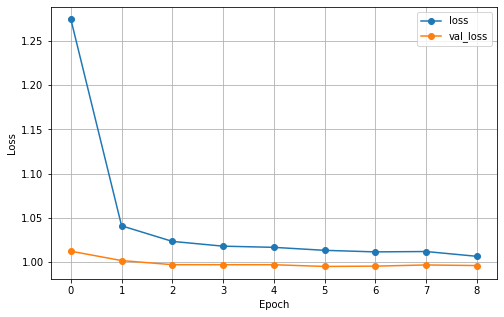

In [55]:
plt.plot(lstm.history['loss'], label='loss', marker = 'o')
plt.plot(lstm.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM Classification

In [56]:
lstm_pred = np.round(model.predict(X_test_final))

63/63 [==============================] - 2s 29ms/step


In [57]:
print('Accuracy %s' % accuracy_score(y_test, lstm_pred))
print('F1-score %s' % f1_score(y_test, lstm_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstm_pred, zero_division=1))

Accuracy 0.557
F1-score [0.         0.71547848 0.         0.         0.         0.
 0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       746
           1       0.56      1.00      0.72      1114
           2       1.00      0.00      0.00        27
           3       1.00      0.00      0.00         4
           4       1.00      0.00      0.00        29
           5       1.00      0.00      0.00        61
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00        18

   micro avg       0.56      0.56      0.56      2000
   macro avg       0.94      0.12      0.09      2000
weighted avg       0.75      0.56      0.40      2000
 samples avg       0.56      0.56      0.56      2000



#CNN Classification

In [58]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 20
filters = 10
kernel_size = 3
hidden_dims = 10

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [59]:
X_train_final[0]

array([  14,   74,    7,    7,  380,   76,   19,  177, 2761,    7,   22,
         74,  123,  110,  814, 6342,   97, 3533,    4,    2,   14,   35,
         59,    7,    7,  380,   76,   19,  698,    3,  195,   15, 5656,
         81,  123,  177, 2071,   22,   97,  575,    3,  250,   73,    8,
         66,  217,   78,   84,    3,   63,  827,  653,   75, 3534,    2,
         35,   14,   74,   73,    8,   66,  217,   78,   84,    3,   63,
        827,  653,   75,  764,    2,   35,   14,   74,   73,    8,   66,
        217,   78,   84,    3,   63,  827,  653,   75, 3534,    2,   35,
         14,   74,   73,    8,   66,  217,   78,   84,    3,   63,  827,
        653,   10,  449,    2,   35,   14,   74,   73,    8,   66,  217,
         78,   84,    3,   63,  827,  653,   75, 3534,    2,   35,   14,
         74,   73,    8,   66,  217,   78,   84,    3,   63,  827,  653,
         75,  764,    2,   35,    9,   73,    8,   66,  217,   78,   84,
          3,   63,  827,  653,   75, 3534,    2,   

In [60]:
model = Sequential()

model.add(Embedding(max_features, embed_size))
model.add(Dropout(0.4))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

#vanilla dense layer
model.add(Dense(hidden_dims))
model.add(Dropout(0.4))
model.add(Activation('relu'))

#output layer
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 10)          3850      
                                                                 
 global_max_pooling1d (Globa  (None, 10)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                      

In [61]:
cnn= model.fit(X_train_final, y_train, 
          batch_size = batch_size, 
          epochs=epochs, 
          shuffle=True, 
          validation_split=0.1,
          callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
113/113 [==============================] - 12s 97ms/step - loss: 1.8349 - accuracy: 0.4035 - val_loss: 1.3749 - val_accuracy: 0.5362
Epoch 2/20
113/113 [==============================] - 11s 93ms/step - loss: 1.2761 - accuracy: 0.5243 - val_loss: 0.9677 - val_accuracy: 0.6425
Epoch 3/20
113/113 [==============================] - 11s 94ms/step - loss: 1.0434 - accuracy: 0.6171 - val_loss: 0.8830 - val_accuracy: 0.6600
Epoch 4/20
113/113 [==============================] - 11s 93ms/step - loss: 0.9293 - accuracy: 0.6704 - val_loss: 0.8261 - val_accuracy: 0.7050
Epoch 5/20
113/113 [==============================] - 11s 95ms/step - loss: 0.8225 - accuracy: 0.7119 - val_loss: 0.7875 - val_accuracy: 0.7188
Epoch 6/20
113/113 [==============================] - 11s 93ms/step - loss: 0.7304 - accuracy: 0.7543 - val_loss: 0.7785 - val_accuracy: 0.7237
Epoch 7/20
113/113 [==============================] - 11s 93ms/step - loss: 0.6766 - accuracy: 0.7811 - val_loss: 0.7662 - val_accuracy:

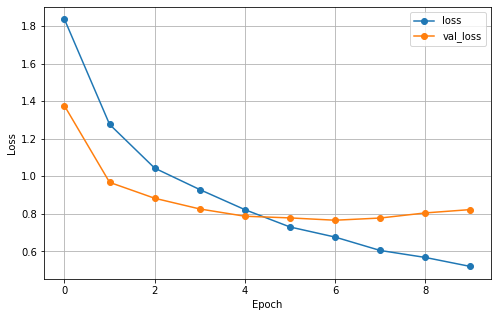

In [62]:
plt.plot(cnn.history['loss'], label='loss', marker = 'o')
plt.plot(cnn.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN Classification

In [63]:
cnn_pred = np.round(model.predict(X_test_final))

63/63 [==============================] - 1s 8ms/step


In [64]:
print('Accuracy %s' % accuracy_score(y_test, cnn_pred))
print('F1-score %s' % f1_score(y_test, cnn_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnn_pred, zero_division=1))

Accuracy 0.6975
F1-score [0.67119565 0.80446429 0.         0.         0.         0.
 0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       746
           1       0.80      0.81      0.80      1114
           2       1.00      0.00      0.00        27
           3       1.00      0.00      0.00         4
           4       1.00      0.00      0.00        29
           5       1.00      0.00      0.00        61
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00        18

   micro avg       0.75      0.70      0.72      2000
   macro avg       0.94      0.18      0.18      2000
weighted avg       0.77      0.70      0.70      2000
 samples avg       0.77      0.70      0.70      2000



#Classification with FastText

In [65]:
import codecs
#load embeddings
print('loading word embeddings...')
#dictionary where the keys will be words and the values will be coefficients 
embeddings_index = {}
f = codecs.open('../content/drive/MyDrive/Progetto_TA_2022/embeddings/cc.pt.300.vec', encoding='utf-8')
for line in f:
    #values returns a list where the first element is a word and the others are the vector coefficients for that word
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 2000000 word vectors


In [66]:
maxlen= 200
embed_size = 300 #standard length for FastTest
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences (list_tokenized_test, maxlen=maxlen)

In [67]:
max_features = 20000
tokenizer = Tokenizer (num_words = max_features)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  36295


In [68]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 753


In [69]:
word_index

{'que': 1,
 'eu': 2,
 'o': 3,
 'e': 4,
 'a': 5,
 'de': 6,
 'não': 7,
 'é': 8,
 'você': 9,
 'me': 10,
 'pra': 11,
 'se': 12,
 'um': 13,
 'te': 14,
 'do': 15,
 'meu': 16,
 'no': 17,
 'na': 18,
 'mais': 19,
 'em': 20,
 'amor': 21,
 'vai': 22,
 'com': 23,
 'só': 24,
 'vou': 25,
 'da': 26,
 'mas': 27,
 'por': 28,
 'seu': 29,
 'uma': 30,
 'tem': 31,
 'tudo': 32,
 'minha': 33,
 'sem': 34,
 'quero': 35,
 'já': 36,
 'quando': 37,
 'quem': 38,
 'mim': 39,
 'ela': 40,
 'ser': 41,
 'sou': 42,
 'vida': 43,
 'os': 44,
 'sei': 45,
 'como': 46,
 'coração': 47,
 'tá': 48,
 'as': 49,
 'gente': 50,
 'bem': 51,
 'faz': 52,
 'foi': 53,
 'vem': 54,
 'tô': 55,
 'dia': 56,
 'sua': 57,
 'nem': 58,
 'assim': 59,
 'aqui': 60,
 'ver': 61,
 'sempre': 62,
 'tempo': 63,
 'agora': 64,
 'mundo': 65,
 'tão': 66,
 'para': 67,
 'quer': 68,
 'x': 69,
 'nada': 70,
 'até': 71,
 'pode': 72,
 'hoje': 73,
 'ter': 74,
 'essa': 75,
 'nunca': 76,
 'ou': 77,
 'lá': 78,
 'fazer': 79,
 'ninguém': 80,
 'ao': 81,
 'todo': 82,
 'esse':

In [70]:
words_not_found[:50]

['leandrostz',
 '\xa0',
 'paparará',
 'piririm',
 'manhã£',
 'cafã',
 'thururuthu',
 'pêrêrê',
 'rêen',
 'arê',
 'spyro',
 'parpando',
 'umbabarauma',
 'pararara',
 'lôrabúrra',
 'laun',
 'dararara',
 'daron',
 'dealema',
 'domênica',
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0',
 'popoy',
 'pararapa',
 'acota',
 'ôôôôôôôôôôô',
 'dumingaz',
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0',
 'guarija',
 'lonest',
 'giselda',
 'enrow',
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0',
 'aaaaaahhhh',
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0',
 'oquêcêque',
 'tihuana',
 'pêti',
 'pêta',
 'flista',
 'alacazam',
 'larilariaaaa',
 'tirim',
 'vivro',
 'thara',
 '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0',
 'larala',
 'etzinho',
 'uououo',
 'tcharara',
 'iêiêié']

#LSTM Training with FastText 

In [71]:
model = Sequential()
model.add(Embedding(nb_words, embed_size, weights = [embedding_matrix], trainable = False))
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.4))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         6000000   
                                                                 
 lstm_1 (LSTM)               (None, None, 20)          25680     
                                                                 
 dropout_4 (Dropout)         (None, None, 20)          0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                1344      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [72]:
lstm_FT = model.fit(X_train_final, y_train,
                 batch_size=batch_size, 
                 epochs=10, 
                 shuffle = True, 
                 validation_split=0.2,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

lstm_FT

Epoch 1/10
100/100 [==============================] - 15s 129ms/step - loss: 1.2403 - accuracy: 0.5028 - val_loss: 1.0448 - val_accuracy: 0.5281
Epoch 2/10
100/100 [==============================] - 12s 122ms/step - loss: 1.0020 - accuracy: 0.5423 - val_loss: 1.0237 - val_accuracy: 0.5281
Epoch 3/10
100/100 [==============================] - 12s 121ms/step - loss: 0.9874 - accuracy: 0.5531 - val_loss: 1.0146 - val_accuracy: 0.5281
Epoch 4/10
100/100 [==============================] - 12s 121ms/step - loss: 0.9781 - accuracy: 0.5783 - val_loss: 1.0012 - val_accuracy: 0.5519
Epoch 5/10
100/100 [==============================] - 12s 122ms/step - loss: 0.9659 - accuracy: 0.5814 - val_loss: 0.9895 - val_accuracy: 0.5775
Epoch 6/10
100/100 [==============================] - 12s 122ms/step - loss: 0.9596 - accuracy: 0.5950 - val_loss: 0.9825 - val_accuracy: 0.5738
Epoch 7/10
100/100 [==============================] - 12s 123ms/step - loss: 0.9361 - accuracy: 0.6197 - val_loss: 0.9550 - val_ac

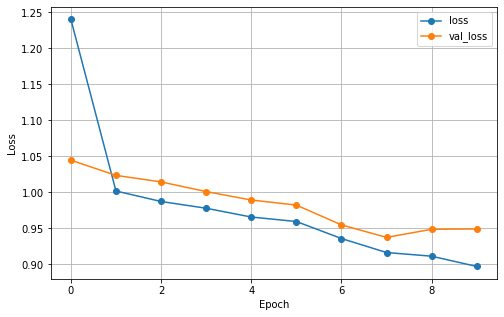

In [73]:
plt.plot(lstm_FT.history['loss'], label='loss', marker = 'o')
plt.plot(lstm_FT.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM with FT

In [74]:
lstmFT_pred = np.round(model.predict(X_test_final))

63/63 [==============================] - 2s 29ms/step


In [75]:
print('Accuracy %s' % accuracy_score(y_test, lstmFT_pred))
print('F1-score %s' % f1_score(y_test, lstmFT_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstmFT_pred, zero_division=1))

Accuracy 0.4465
F1-score [0.58536585 0.58153477 0.         0.         0.         0.
 0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.63      0.55      0.59       746
           1       0.88      0.44      0.58      1114
           2       1.00      0.00      0.00        27
           3       1.00      0.00      0.00         4
           4       1.00      0.00      0.00        29
           5       1.00      0.00      0.00        61
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00        18

   micro avg       0.74      0.45      0.56      2000
   macro avg       0.94      0.12      0.15      2000
weighted avg       0.79      0.45      0.54      2000
 samples avg       0.85      0.45      0.45      2000



#CNN classification with FastText

In [76]:
model = Sequential()

model.add(Embedding(max_features, embed_size, weights = [embedding_matrix], trainable =False))
model.add(Dropout(0.4))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

#vanilla dense layer
model.add(Dense(hidden_dims, activation= 'relu'))
model.add(Dropout(0.4))
model.add(Activation('relu'))

#output layer
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         6000000   
                                                                 
 dropout_6 (Dropout)         (None, None, 300)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 10)          9010      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                      

In [77]:
cnn_FT= model.fit(X_train_final, y_train, 
          batch_size = batch_size, 
          epochs=epochs, 
          shuffle=True, 
          validation_split=0.1,
          callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
113/113 [==============================] - 15s 124ms/step - loss: 1.5032 - accuracy: 0.4353 - val_loss: 1.1130 - val_accuracy: 0.5838
Epoch 2/20
113/113 [==============================] - 12s 110ms/step - loss: 1.2238 - accuracy: 0.5074 - val_loss: 1.0035 - val_accuracy: 0.5913
Epoch 3/20
113/113 [==============================] - 12s 110ms/step - loss: 1.1084 - accuracy: 0.5153 - val_loss: 0.9565 - val_accuracy: 0.6012
Epoch 4/20
113/113 [==============================] - 12s 110ms/step - loss: 1.0595 - accuracy: 0.5553 - val_loss: 0.9296 - val_accuracy: 0.6212
Epoch 5/20
113/113 [==============================] - 13s 111ms/step - loss: 1.0123 - accuracy: 0.5925 - val_loss: 0.9185 - val_accuracy: 0.6162
Epoch 6/20
113/113 [==============================] - 12s 110ms/step - loss: 0.9936 - accuracy: 0.6093 - val_loss: 0.9153 - val_accuracy: 0.6125
Epoch 7/20
113/113 [==============================] - 12s 110ms/step - loss: 0.9682 - accuracy: 0.6299 - val_loss: 0.8871 - val_ac

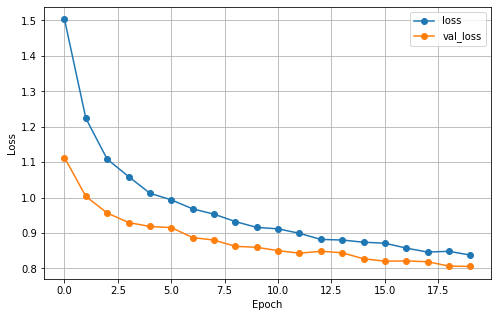

In [78]:
plt.plot(cnn_FT.history['loss'], label='loss', marker = 'o')
plt.plot(cnn_FT.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN with FastText

In [79]:
cnnFT_pred = np.round(model.predict(X_test_final))

63/63 [==============================] - 2s 26ms/step


In [80]:
print('Accuracy %s' % accuracy_score(y_test, cnnFT_pred))
print('F1-score %s' % f1_score(y_test, cnnFT_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnnFT_pred, zero_division=1))

Accuracy 0.6475
F1-score [0.60044477 0.7865665  0.         0.         0.         0.
 0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.54      0.60       746
           1       0.77      0.80      0.79      1114
           2       1.00      0.00      0.00        27
           3       1.00      0.00      0.00         4
           4       1.00      0.00      0.00        29
           5       1.00      0.00      0.00        61
           6       1.00      0.00      0.00         1
           7       1.00      0.00      0.00        18

   micro avg       0.74      0.65      0.69      2000
   macro avg       0.93      0.17      0.17      2000
weighted avg       0.75      0.65      0.66      2000
 samples avg       0.77      0.65      0.65      2000



#Classification with Word2Vec

In [81]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [82]:
pip install --upgrade gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [83]:
import gensim
from gensim.models import Word2Vec

In [84]:
df_pt['Genre_number'] = df_pt['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in df_pt['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)
    
  if i == 'Jazz':
    numbers.append(3)

  if i == 'Folk':
   numbers.append(4)
  
  if i == 'Indie':
   numbers.append(5)

  if i == 'R&B':
    numbers.append(6)
  
  elif i == 'Electronic':
    numbers.append(7)
  
  

In [85]:
df_pt['Genre_number'] = numbers

In [86]:
#Gensim word2vec requires sentences in input so i split the lyrics into sentences
sentence_splitter = nltk.data.load('tokenizers/punkt/portuguese.pickle')
sentences =[]
sum=0
for lyrics in df_pt['Lyrics']:
  sents = sentence_splitter.tokenize(lyrics.strip())
  sum+=len(sents)
  for sent in sents:
    sentences.append(sent.split())
print(sum)
print(len(sentences))

10000
10000


In [87]:
#checking that the sentences are in the correct format
for sent in sentences[:5]:
  print(sent, "\n")

['intro', 'verso', 'e', 'b', 'g', 'd', 'a', 'e', 'refrão', 'e', 'b', 'g', 'd', 'a', 'e', 'passagem', 'e', 'b', 'g', 'd', 'a', 'e'] 

['como', 'uma', 'flecha', 'em', 'meu', 'coração', 'entrou', 'rasgando', 'no', 'peito', 'o', 'seu', 'amor', 'seu', 'jeito', 'lindo', 'de', 'ser', 'me', 'fez', 'voltar', 'a', 'viver', 'e', 'esquecer', 'toda', 'dor', 'parou', 'a', 'chuva', 'nasceu', 'o', 'sol', 'tá', 'colorido', 'meu', 'mundo', 'eu', 'nunca', 'fui', 'tão', 'feliz', 'então', 'por', 'isso', 'que', 'eu', 'fiz', 'essa', 'canção', 'pra', 'você', 'te', 'amo', 'nana', 'nana', 'nana', 'eu', 'te', 'ofereço', 'essa', 'canção', 'te', 'amo', 'e', 'te', 'prometo', 'por', 'toda', 'a', 'vida', 'o', 'meu', 'amor', 'nessa', 'canção', 'pra', 'você', 'com', 'esse', 'amor', 'eu', 'tanto', 'sonhei', 'mas', 'era', 'quase', 'impossivel', 'acreditar', 'que', 'eu', 'iria', 'encontrar', 'a', 'minha', 'lua', 'meu', 'mar', 'e', 'me', 'aparece', 'você', 'você', 'é', 'o', 'brilho', 'do', 'meu', 'olhar', 'é', 'tudo', 'o',

In [88]:
#creating the w2v embeddings
w2v_model=gensim.models.Word2Vec(sentences=sentences, vector_size=100, window=10, min_count=1)

In [89]:
w2v_model.train(sentences, epochs=10, total_examples=len(sentences))

(12832988, 17281120)

In [90]:
#total num of extracted words
vocab = w2v_model.wv.index_to_key
print("Total number of words: ", len(vocab))

Total number of words:  39734


In [91]:
w2v_model.wv.most_similar('ela')

[('dela', 0.6007353663444519),
 ('gostosa', 0.44912680983543396),
 ('pi', 0.43537890911102295),
 ('mulher', 0.43377038836479187),
 ('nela', 0.42559707164764404),
 ('raptada', 0.4135790169239044),
 ('vizinha', 0.40950629115104675),
 ('amiga', 0.40860673785209656),
 ('poderosa', 0.40359237790107727),
 ('você', 0.3963332772254944)]

In [92]:
#creating a dictionary with words in vocab and their embeddings. It will be used to create the embedding matrix 

word_vec_dict={}

for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)

len(word_vec_dict)

39734

In [93]:
#finding the max length of the lyrics
maxi = -1
for i, lyrics in enumerate(df_pt['Lyrics']):
  tokens=lyrics.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)

print(maxi)

3874


In [94]:
#integer encoding the words in the lyrics using Keras Tokenizer
tok=Tokenizer()
tok.fit_on_texts(df_pt['Lyrics'])
vocab_size = len(tok.word_index) +1
encoded_lyrics = tok.texts_to_sequences(df_pt['Lyrics'])

In [95]:
max_lyrics_len=maxi
embed_dim = 100

#padding every sequence to the max length
padded_lyrics=pad_sequences(encoded_lyrics, maxlen=max_lyrics_len, padding='post')
padded_lyrics.shape

(10000, 3874)

In [96]:
#creating the embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word, i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None: #if the word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
    #if the word is not found, the vector corresponding to the embedding will be filled with zeros

In [97]:
Y= to_categorical(df_pt['Genre_number'], 8) #transforming the labels into one hot vectors
x_train,x_test,y_train,y_test=train_test_split(padded_lyrics, Y,test_size=0.20,random_state=42)

In [98]:
y_train.shape, y_test.shape

((8000, 8), (2000, 8))

#LSTM Classification with Word2vec

In [99]:
from keras.initializers import Constant


In [100]:
epochs=5
batch_size=64

In [101]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable = False, embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(12, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 3874, 100)         3981100   
                                                                 
 lstm_2 (LSTM)               (None, 12)                5424      
                                                                 
 dropout_8 (Dropout)         (None, 12)                0         
                                                                 
 dense_8 (Dense)             (None, 24)                312       
                                                                 
 dropout_9 (Dropout)         (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 200       
                                                                 
Total params: 3,987,036
Trainable params: 5,936
Non-tr

In [102]:
lstm_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
lstm_w2v

Epoch 1/5
100/100 [==============================] - 371s 4s/step - loss: 1.5970 - accuracy: 0.5369 - val_loss: 1.2531 - val_accuracy: 0.5663
Epoch 2/5
100/100 [==============================] - 362s 4s/step - loss: 1.1728 - accuracy: 0.5381 - val_loss: 1.0793 - val_accuracy: 0.5663
Epoch 3/5
100/100 [==============================] - 365s 4s/step - loss: 1.0774 - accuracy: 0.5381 - val_loss: 1.0266 - val_accuracy: 0.5663
Epoch 4/5
100/100 [==============================] - 362s 4s/step - loss: 1.0446 - accuracy: 0.5381 - val_loss: 1.0049 - val_accuracy: 0.5663
Epoch 5/5
100/100 [==============================] - 361s 4s/step - loss: 1.0297 - accuracy: 0.5381 - val_loss: 0.9938 - val_accuracy: 0.5663


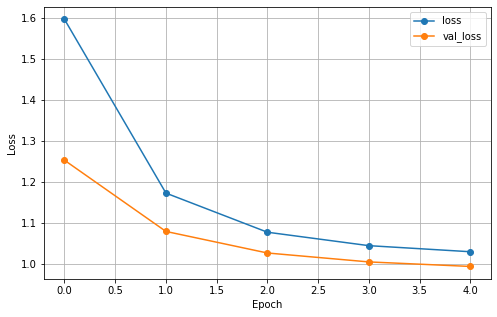

In [103]:
plt.plot(lstm_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(lstm_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM CLassification with w2v

In [104]:
lstmW2V_pred = np.round(model.predict(x_test)) #x_test from last padding and train/test splitting

63/63 [==============================] - 28s 433ms/step


In [105]:
print('Accuracy %s' % accuracy_score(y_test, lstmW2V_pred))
print('F1-score %s' % f1_score(y_test, lstmW2V_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstmW2V_pred, zero_division=1))

Accuracy 0.534
F1-score [0.         0.69621904 0.         0.         0.         0.
 0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       788
           1       0.53      1.00      0.70      1068
           2       1.00      0.00      0.00        19
           3       1.00      0.00      0.00         5
           4       1.00      0.00      0.00        27
           5       1.00      0.00      0.00        75
           6       1.00      0.00      0.00         4
           7       1.00      0.00      0.00        14

   micro avg       0.53      0.53      0.53      2000
   macro avg       0.94      0.12      0.09      2000
weighted avg       0.75      0.53      0.37      2000
 samples avg       0.53      0.53      0.53      2000



#CNN Classification with Word2Vec

In [106]:
filters=10
kernel_size=3
epochs=20

In [107]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable= False, embeddings_initializer=Constant(embed_matrix)))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 3874, 100)         3981100   
                                                                 
 conv1d_2 (Conv1D)           (None, 3872, 10)          3010      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                352       
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                      

In [108]:
cnn_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
100/100 [==============================] - 41s 402ms/step - loss: 1.3351 - accuracy: 0.4891 - val_loss: 0.9672 - val_accuracy: 0.5663
Epoch 2/20
100/100 [==============================] - 38s 380ms/step - loss: 1.0424 - accuracy: 0.5387 - val_loss: 0.9448 - val_accuracy: 0.5663
Epoch 3/20
100/100 [==============================] - 38s 383ms/step - loss: 1.0128 - accuracy: 0.5533 - val_loss: 0.9816 - val_accuracy: 0.5744
Epoch 4/20
100/100 [==============================] - 38s 381ms/step - loss: 1.0002 - accuracy: 0.5661 - val_loss: 0.9226 - val_accuracy: 0.6338
Epoch 5/20
100/100 [==============================] - 40s 401ms/step - loss: 0.9841 - accuracy: 0.5806 - val_loss: 0.9240 - val_accuracy: 0.6725
Epoch 6/20
100/100 [==============================] - 38s 380ms/step - loss: 0.9620 - accuracy: 0.5922 - val_loss: 0.9467 - val_accuracy: 0.6469
Epoch 7/20
100/100 [==============================] - 40s 401ms/step - loss: 0.9486 - accuracy: 0.6067 - val_loss: 0.9384 - val_ac

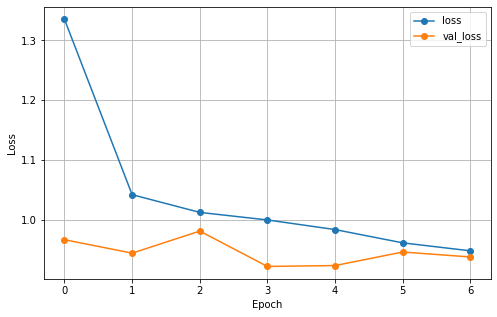

In [109]:
plt.plot(cnn_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(cnn_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN Classification with w2v

In [110]:
cnnW2V_pred = np.round(model.predict(x_test))

63/63 [==============================] - 4s 58ms/step


In [111]:
print('Accuracy %s' % accuracy_score(y_test, cnnW2V_pred))
print('F1-score %s' % f1_score(y_test, cnnW2V_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnnW2V_pred, zero_division=1))

Accuracy 0.2945
F1-score [0.21581197 0.5995086  0.         0.         0.         0.
 0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.13      0.22       788
           1       0.87      0.46      0.60      1068
           2       1.00      0.00      0.00        19
           3       1.00      0.00      0.00         5
           4       1.00      0.00      0.00        27
           5       1.00      0.00      0.00        75
           6       1.00      0.00      0.00         4
           7       1.00      0.00      0.00        14

   micro avg       0.83      0.29      0.44      2000
   macro avg       0.94      0.07      0.10      2000
weighted avg       0.81      0.29      0.41      2000
 samples avg       0.94      0.29      0.29      2000

